<a href="https://colab.research.google.com/github/royerlozano/CUADERNO-DE-ROYER/blob/main/RoyerLozanoPreg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

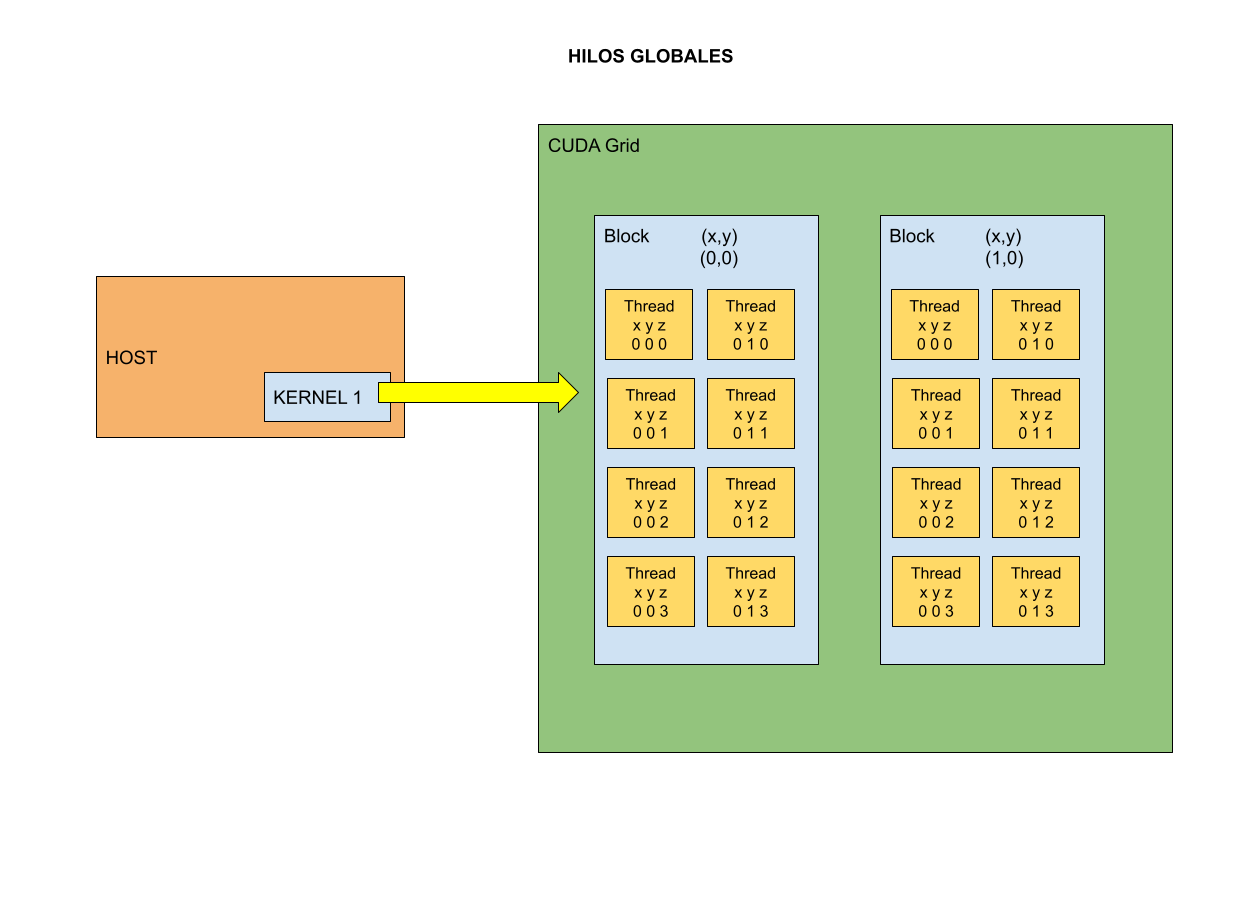

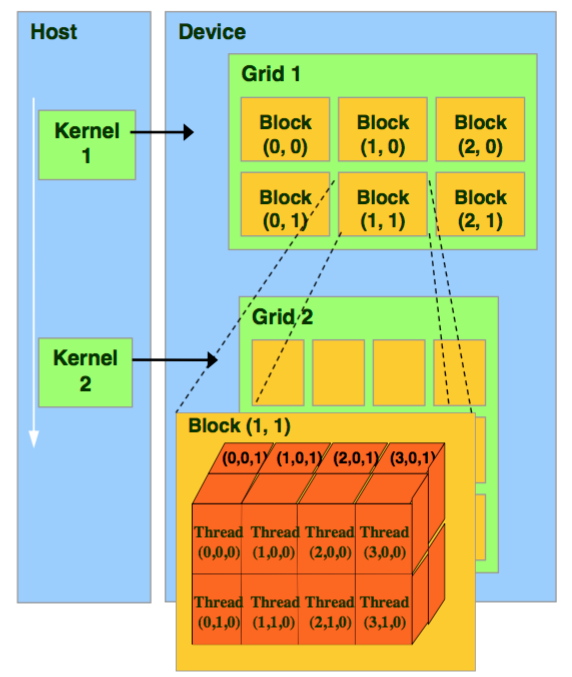

https://nyu-cds.github.io/python-gpu/02-cuda/

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 1.24 ms (started: 2021-03-15 14:43:51 +00:00)


In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>

__global__
void saxpy(int n, float a, float *x, float *y)
{
  int i = blockIdx.x*blockDim.x + threadIdx.x;
  if (i < n) y[i] = a*x[i] + y[i];
}

int main(void)
{
  int N = 20 * (1 << 20);
  float *x, *y, *d_x, *d_y;
  x = (float*)malloc(N*sizeof(float));
  y = (float*)malloc(N*sizeof(float));

  cudaMalloc(&d_x, N*sizeof(float)); 
  cudaMalloc(&d_y, N*sizeof(float));

  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaMemcpy(d_x, x, N*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(d_y, y, N*sizeof(float), cudaMemcpyHostToDevice);

  cudaEventRecord(start);

  // Perform SAXPY on 1M elements
  saxpy<<<(N+511)/512, 512>>>(N, 2.0f, d_x, d_y);

  cudaEventRecord(stop);

  cudaMemcpy(y, d_y, N*sizeof(float), cudaMemcpyDeviceToHost);

  cudaEventSynchronize(stop);
  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);

  float maxError = 0.0f;
  for (int i = 0; i < N; i++) {
    maxError = max(maxError, abs(y[i]-4.0f));
  }

  printf("Max error: %fn", maxError);
  printf("Effective Bandwidth (GB/s): %fn", N*4*3/milliseconds/1e6);
}

Max error: 0.000000nEffective Bandwidth (GB/s): 113.661024n
time: 1.84 s (started: 2021-03-15 14:44:05 +00:00)


In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>

__global__ void helloworld()
{ 
    printf("Hola Mundo..! Soy el hilo con id bloque: {%d %d}, id de hilo{ %d %d %d }\n", 
	  blockIdx.x, blockIdx.y, threadIdx.x, threadIdx.y, threadIdx.z);
}

int main()
{
    dim3 threads(1, 2, 4); //--nro de hilos por bloque
    dim3 grid(3, 1); //--nro de bloques por grid
    helloworld <<< grid, threads >>> (); //--se define un hilo por bloque
    cudaDeviceSynchronize();
    return 0;

}

UsageError: Cell magic `%%cu` not found.


In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>

__global__ void helloworld(){    
  printf("Hola Mundo..! Soy el hilo con id bloque: {%d %d} del id de hilo{ %d %d %d }\n",
          blockIdx.x, blockIdx.y, threadIdx.x, threadIdx.y, threadIdx.z);

}

int main()
{
  helloworld <<<1, 1>>>(); //--se define un hilo por bloque
  cudaDeviceSynchronize();
  return 0;
}

Hola Mundo..! Soy el hilo con id bloque: {0 0} del id de hilo{ 0 0 0 }



In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>
#include <cuda.h>
#include <cuda_runtime.h>


#define MAX_ERR 1e-6

#include <stdio.h>
#include <stdlib.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#define N 1000 // tamano de los vectores
#define BLOCK 5 // tamano del bloque
// declaracion de funciones
// GLOBAL: funcion llamada desde el host y ejecutada en el device (kernel)
__global__ void suma(float* a, float* b, float* c)
{
int myID = threadIdx.x + blockDim.x * blockIdx.x;
// Solo trabajan N hilos
if (myID < N)
{
c[myID] = a[myID] + b[myID];
}
}
// MAIN: rutina principal ejecutada en el host
int main(int argc, char** argv)
{
// declaraciones
float* vector1, * vector2, * resultado;
float* dev_vector1, * dev_vector2, * dev_resultado;
 
// reserva en el host
vector1 = (float*)malloc(N * sizeof(float));
vector2 = (float*)malloc(N * sizeof(float));
resultado = (float*)malloc(N * sizeof(float));
// reserva en el device
cudaMalloc((void**)&dev_vector1, N * sizeof(float));
cudaMalloc((void**)&dev_vector2, N * sizeof(float));
cudaMalloc((void**)&dev_resultado, N * sizeof(float));
// inicializacion de vectores
for (int i = 0; i < N; i++)
{
vector1[i] = (float)rand() / RAND_MAX;
vector2[i] = (float)rand() / RAND_MAX;
}
// copia de datos hacia el device
cudaMemcpy(dev_vector1, vector1, N * sizeof(float), cudaMemcpyHostToDevice);
cudaMemcpy(dev_vector2, vector2, N * sizeof(float), cudaMemcpyHostToDevice);
// lanzamiento del kernel
// calculamos el numero de bloques necesario para un tamaño de bloque fijo
int nBloques = N / BLOCK;
if (N % BLOCK != 0)
{
nBloques = nBloques + 1;
}
int hilosB = BLOCK;
printf("Vector de %d elementos\n", N);
printf("Lanzamiento con %d bloques (%d hilos)\n", nBloques, nBloques * hilosB);
suma << < nBloques, hilosB >> > (dev_vector1, dev_vector2, dev_resultado);
// recogida de datos desde el device
cudaMemcpy(resultado, dev_resultado, N * sizeof(float), cudaMemcpyDeviceToHost);
// impresion de resultados
printf("> vector1:\n");
for (int i = 0; i < N; i++)
{
printf("%.2f ", vector1[i]);
}
printf("\n");
printf("> vector2:\n");
for (int i = 0; i < N; i++)
{
printf("%.2f ", vector2[i]);
}
printf("\n");
printf("> SUMA:\n");
for (int i = 0; i < N; i++)
{
printf("%.2f ", resultado[i]);
}
printf("\n");
// liberamos memoria en el device
cudaFree(dev_vector1);
cudaFree(dev_vector2);
cudaFree(dev_resultado);
// salida
printf("\npulsa INTRO para finalizar...");
fflush(stdin);
char tecla = getchar();
return 0;
}


Vector de 1000 elementos
Lanzamiento con 200 bloques (1000 hilos)
> vector1:
0.84 0.78 0.91 0.34 0.28 0.48 0.36 0.95 0.64 0.14 0.02 0.14 0.16 0.13 1.00 0.51 0.61 0.64 0.49 0.29 0.53 0.40 0.28 0.81 0.07 0.53 0.19 0.89 0.06 0.46 0.24 0.90 0.27 0.38 0.51 0.53 0.44 0.93 0.28 0.64 0.69 0.44 0.83 0.23 0.35 0.96 0.66 0.44 0.40 0.68 0.48 0.95 0.15 0.64 0.62 0.79 0.45 0.19 0.56 0.17 0.10 0.50 0.98 0.68 0.75 0.29 0.58 0.15 0.13 0.16 0.07 0.05 0.18 0.80 0.66 0.64 0.09 0.52 0.07 0.46 0.57 0.05 1.00 0.89 1.00 0.87 0.00 0.59 0.16 0.91 0.36 0.58 0.69 0.53 0.30 0.58 0.75 0.04 0.83 0.87 0.98 0.90 0.67 0.16 0.89 0.65 0.63 0.70 0.33 0.07 0.22 0.51 0.28 0.72 0.47 0.94 0.34 0.43 0.34 0.83 0.68 0.48 0.71 0.62 0.41 0.67 0.35 0.61 0.73 0.74 0.92 0.65 0.53 0.26 0.69 0.11 0.58 0.67 0.78 0.33 0.98 0.83 0.19 0.96 0.76 0.12 0.38 0.94 0.86 0.79 0.30 0.91 0.50 0.16 0.86 0.46 0.50 0.18 0.73 0.60 0.84 0.18 0.50 0.14 0.32 0.91 0.84 0.50 0.39 0.61 0.15 0.11 0.36 0.33 0.43 0.58 0.66 0.49 0.88 0.52 0.56 0.83 0.24 0.73 0.9

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>

__global__ void addKernel(int* c, const int* a, const int* b, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        c[i] = a[i] + b[i];
        
    }
}

// Helper function for using CUDA to add vectors in parallel.
void addWithCuda(int* c, const int* a, const int* b, int size) {
    int* dev_a = nullptr;
    int* dev_b = nullptr;
    int* dev_c = nullptr;

    // Allocate GPU buffers for three vectors (two input, one output)
    cudaMalloc((void**)&dev_c, size * sizeof(int));
    cudaMalloc((void**)&dev_a, size * sizeof(int));
    cudaMalloc((void**)&dev_b, size * sizeof(int));

    // Copy input vectors from host memory to GPU buffers.
    cudaMemcpy(dev_a, a, size * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, size * sizeof(int), cudaMemcpyHostToDevice);

    // Launch a kernel on the GPU with one thread for each element.
    // 2 is number of computational blocks and (size + 1) / 2 is a number of threads in a block
    addKernel<<<2, (size + 1) / 2>>>(dev_c, dev_a, dev_b, size);
    
    // cudaDeviceSynchronize waits for the kernel to finish, and returns
    // any errors encountered during the launch.
    cudaDeviceSynchronize();

    // Copy output vector from GPU buffer to host memory.
    cudaMemcpy(c, dev_c, size * sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(dev_c);
    cudaFree(dev_a);
    cudaFree(dev_b);
}

int main(int argc, char** argv) {
    
    const int arraySize = 100;
    int a[arraySize]={0};
    int b[arraySize]={0};
    for(int j = 0; j < arraySize; j++){
      a[j] = j;
      b[j] = j;
    }
    
    int c[arraySize] = { 0 };

    addWithCuda(c, a, b, arraySize);

    printf("{1, 2, 3, 4, 5} + {1,2,3,4,5} = {%d, %d, %d, %d, %d,%d,%d,%d,%d}\n", c[0], c[1], c[2], c[3], c[4],c[5],c[6],c[7],c[8],c[9],c[10]);
    for(int j = 0; j < arraySize; j++){
      printf("a = %d ", a[j]);
    }
    printf("\n");
    for(int j = 0; j < arraySize; j++){
      printf("b = %d ", b[j]);
    }
    printf("\n");
    for(int j = 0; j < arraySize; j++){
      printf("c = %d\n", c[j]);
    }
    

    cudaDeviceReset();

    return 0;
}

{1, 2, 3, 4, 5} + {1,2,3,4,5} = {0, 2, 4, 6, 8,10,12,14,16}
a = 0 a = 1 a = 2 a = 3 a = 4 a = 5 a = 6 a = 7 a = 8 a = 9 a = 10 a = 11 a = 12 a = 13 a = 14 a = 15 a = 16 a = 17 a = 18 a = 19 a = 20 a = 21 a = 22 a = 23 a = 24 a = 25 a = 26 a = 27 a = 28 a = 29 a = 30 a = 31 a = 32 a = 33 a = 34 a = 35 a = 36 a = 37 a = 38 a = 39 a = 40 a = 41 a = 42 a = 43 a = 44 a = 45 a = 46 a = 47 a = 48 a = 49 a = 50 a = 51 a = 52 a = 53 a = 54 a = 55 a = 56 a = 57 a = 58 a = 59 a = 60 a = 61 a = 62 a = 63 a = 64 a = 65 a = 66 a = 67 a = 68 a = 69 a = 70 a = 71 a = 72 a = 73 a = 74 a = 75 a = 76 a = 77 a = 78 a = 79 a = 80 a = 81 a = 82 a = 83 a = 84 a = 85 a = 86 a = 87 a = 88 a = 89 a = 90 a = 91 a = 92 a = 93 a = 94 a = 95 a = 96 a = 97 a = 98 a = 99 
b = 0 b = 1 b = 2 b = 3 b = 4 b = 5 b = 6 b = 7 b = 8 b = 9 b = 10 b = 11 b = 12 b = 13 b = 14 b = 15 b = 16 b = 17 b = 18 b = 19 b = 20 b = 21 b = 22 b = 23 b = 24 b = 25 b = 26 b = 27 b = 28 b = 29 b = 30 b = 31 b = 32 b = 33 b = 34 b = 35 b = 36 

In [ ]:
const int a[arraySize] = {0, 1, 2, 3, 4, 5,6,7,8,9 };
    const int b[arraySize] = {0, 1, 2, 3, 4, 5,6,7,8,9 };